This notebook is to test the changes proposed in https://github.com/CLIMADA-project/climada_python/pull/846. Let the code run in the respective branch to get the results of the comparison.

In [1]:
import os
import subprocess

import pandas as pd
import matplotlib.pyplot as plt
from  scipy.stats import linregress 

from climada.hazard import TCTracks, TropCyclone
import climada
from climada.util.api_client import Client
client = Client()

/home/roo/miniforge3/envs/climada_flood/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
cwd_temp = os.getcwd()
climada_dir = os.path.dirname(climada.__file__)
os.chdir(climada_dir)
label = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode('ascii').strip()  # subprocess.check_output(["git", "describe"]).strip().decode("utf-8")
print(label)
os.chdir(cwd_temp)

0b218fe9


initiate dataframe for results as results_df

In [3]:
results_file = "results.csv"
if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
else:
    results_df = pd.DataFrame()
    results_df.to_csv(results_file)

Prepare tc_tracks and calculate windfields

In [4]:
# reading tracks
ibtracs = TCTracks.from_ibtracs_netcdf(provider='official', year_range=(2020, 2020))
ibtracs.equal_timestep()
# reading centroids
cent = client.get_centroids()
model = 'H10'
model_kwargs_dict = {
    # 'current':{
        
    # },
    # 'version2':{
    #     'vmax_from_cen':False,
    #     'rho_air_const':1.2,
    # },
    'version3':{
        'vmax_from_cen':False,
        'rho_air_const':1.2,
        'vmax_in_brackets':True,
    },
}
for model_kwargs_label, model_kwargs_i in model_kwargs_dict.items():
    for ind in range(ibtracs.size):
        sid = ibtracs.data[ind].sid
        temp_track = ibtracs.subset({'sid':sid})
        windspeed_tracks = temp_track.data[0].max_sustained_wind * 0.5144444
        temp_tc_haz = TropCyclone.from_tracks(temp_track, centroids=cent, store_windfields=True, model=model, model_kwargs=model_kwargs_i)
        windspeed_windfields = temp_tc_haz.windfields[0].max(axis=1).toarray().squeeze()
        temp_df = pd.DataFrame({'windspeed_climada': windspeed_windfields, 'windspeed_tracks': windspeed_tracks, 'sid': sid, 'model_kwargs_label': model_kwargs_label, 'model': model,})
        results_df = pd.concat([results_df,temp_df])
results_df.to_csv(results_file)

2024-02-06 11:40:31,546 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/roo/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-02-06 11:40:34,357 - climada.hazard.tc_tracks - WARNING - 10 storm events are discarded because no valid wind/pressure values have been found: 2020019S11063, 2020024S14190, 2020140S05094, 2020195N17125, 2020222N26149, ...


/home/roo/miniforge3/envs/climada_flood/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1816: RuntimeWarning: overflow encountered in exp
  denominator = rho_air * np.exp(r_max_norm)
/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1816: RuntimeWarning: overflow encountered in exp
  denominator = rho_air * np.exp(r_max_norm)
/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1816: RuntimeWarning: overflow encountered in exp
  denominator = rho_air * np.exp(r_max_norm)
/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1816: RuntimeWarning: overflow encountered in exp


Text(0, 65, 'r^2: 0.8806668852348659\nintercept: 1.3756564461413099')

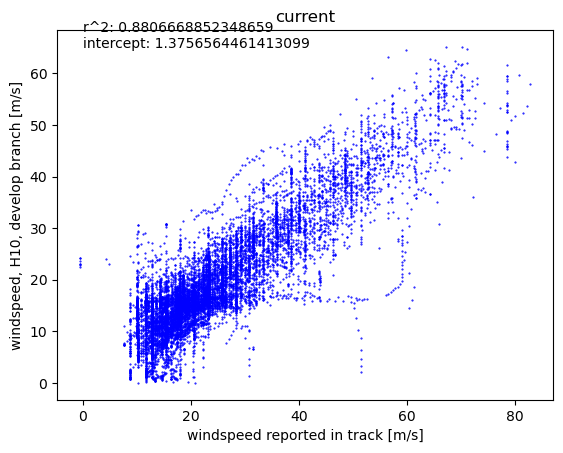

In [7]:
label_select = 'current' # corresponds to keys of the dictionary defined above
selection = (results_df['model_kwargs_label']==label_select) & (results_df.windspeed_climada > 0)
lin_regress_result = linregress(
    results_df[selection].windspeed_tracks,
    results_df[selection].windspeed_climada,
)
plt.plot(results_df[selection].windspeed_tracks,
         results_df[selection].windspeed_climada,
        '.b',
        markersize=1)
plt.xlabel('windspeed reported in track [m/s]')
plt.ylabel('windspeed, ' + model + ', develop branch [m/s]')
plt.title(label_select)
plt.text(x=0,
         y=65,
         s='r^2: ' + str(lin_regress_result.rvalue) + '\n' + 'intercept: ' + str(lin_regress_result.intercept),
        )

Text(0, 65, 'r^2: 0.9209672892984238\nintercept: 2.4912227663499884')

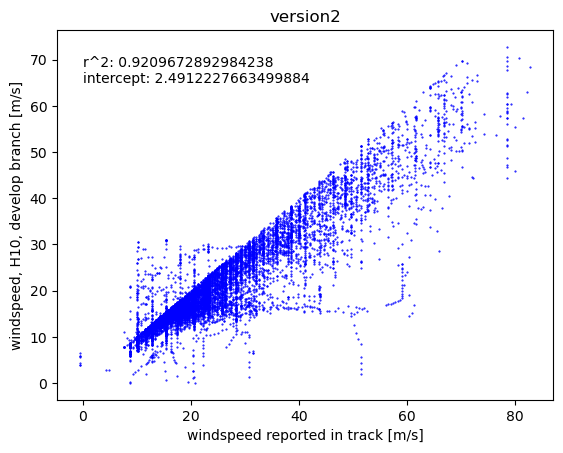

In [8]:
label_select = 'version2' # corresponds to keys of the dictionary defined above
selection = (results_df['model_kwargs_label']==label_select) & (results_df.windspeed_climada > 0)
lin_regress_result = linregress(
    results_df[selection].windspeed_tracks,
    results_df[selection].windspeed_climada,
)
plt.plot(results_df[selection].windspeed_tracks,
         results_df[selection].windspeed_climada,
        '.b',
        markersize=1)
plt.xlabel('windspeed reported in track [m/s]')
plt.ylabel('windspeed, ' + model + ', develop branch [m/s]')
plt.title(label_select)
plt.text(x=0,
         y=65,
         s='r^2: ' + str(lin_regress_result.rvalue) + '\n' + 'intercept: ' + str(lin_regress_result.intercept),
        )

(0.0, 90.0)

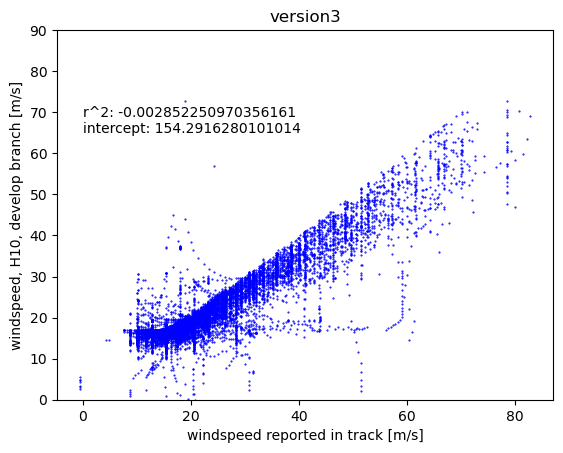

In [11]:
label_select = 'version3' # corresponds to keys of the dictionary defined above, with the changes as implemented by Thomas V.
selection = (results_df['model_kwargs_label']==label_select) & (results_df.windspeed_climada > 0)
lin_regress_result = linregress(
    results_df[selection].windspeed_tracks,
    results_df[selection].windspeed_climada,
)
plt.plot(results_df[selection].windspeed_tracks,
         results_df[selection].windspeed_climada,
        '.b',
        markersize=1)
plt.xlabel('windspeed reported in track [m/s]')
plt.ylabel('windspeed, ' + model + ', develop branch [m/s]')
plt.title(label_select)
plt.text(x=0,
         y=65,
         s='r^2: ' + str(lin_regress_result.rvalue) + '\n' + 'intercept: ' + str(lin_regress_result.intercept),
        )
plt.ylim((0,90)) # why is this needed? what is the track with such a "high" intensity

In [9]:
#investigate single event with very high wind
selection_event = results_df.windspeed_climada > 10000
sid_event = results_df[selection_event].sid
sid_event

30457    2020034S13063
242      2020034S13063
Name: sid, dtype: object

In [5]:
# reading tracks
event_track = TCTracks.from_ibtracs_netcdf(provider='official', storm_id='2020034S13063')
event_track.equal_timestep()
# reading centroids
cent = client.get_centroids()
extent = (45, 75, -25, -10)
cent_event = cent.select(extent=extent)
# calculate windfield
model = 'H10'
model_kwargs_dict = {
    # 'current':{
        
    # },
    # 'version2':{
    #     'vmax_from_cen':False,
    #     'rho_air_const':1.2,
    # },
    'version4':{
        'vmax_from_cen':False,
        'rho_air_const':1.2,
        'vmax_in_brackets':True,
    },
}
for model_kwargs_label, model_kwargs_i in model_kwargs_dict.items():
    windspeed_tracks = event_track.data[0].max_sustained_wind * 0.5144444
    temp_tc_haz = TropCyclone.from_tracks(event_track, centroids=cent_event, store_windfields=True, model=model, model_kwargs=model_kwargs_i)

2024-02-06 14:15:00,843 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/roo/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/home/roo/miniforge3/envs/climada_flood/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1816: RuntimeWarning: overflow encountered in exp
  denominator = rho_air * np.exp(r_max_norm)


<GeoAxes: title={'center': '1-largest Event. ID 1: 2020034S13063'}>

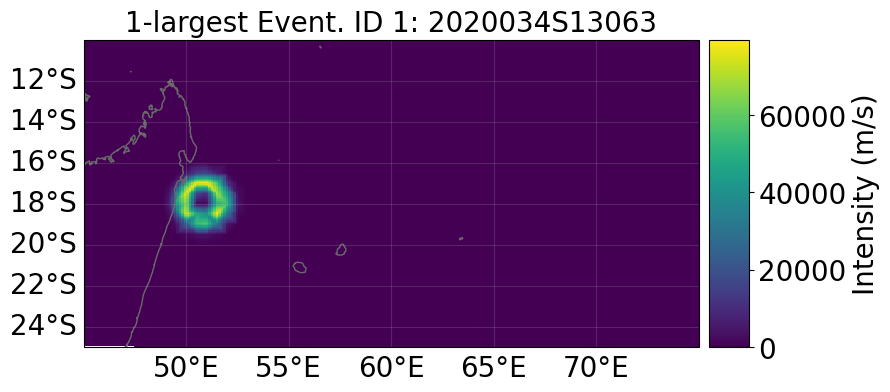

In [6]:
temp_tc_haz.plot_intensity(-1,)

'FRANCISCO'

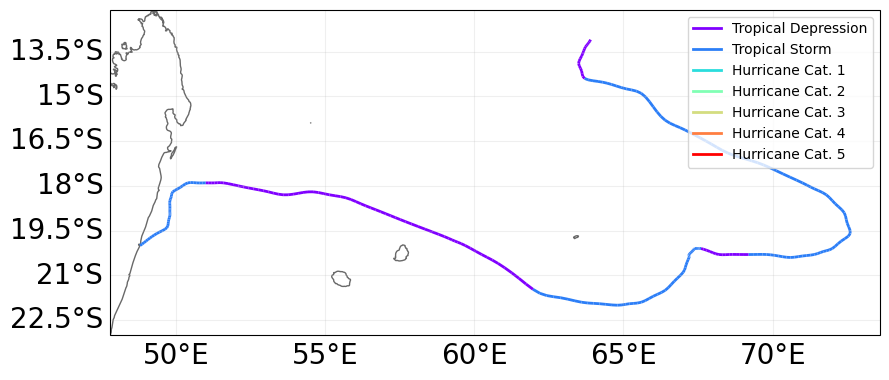

In [4]:
event_track.plot()


In [7]:
event_track.data[0].name

'FRANCISCO'

In [8]:
event_track.data[0]

<xarray.Dataset>
Dimensions:                 (time: 289)
Coordinates:
  * time                    (time) datetime64[ns] 2020-02-03T06:00:00 ... 202...
    lon                     (time) float64 63.9 63.87 63.83 ... 48.94 48.87 48.8
    lat                     (time) float64 -13.1 -13.16 -13.21 ... -19.95 -20.0
Data variables:
    radius_max_wind         (time) float64 0.0 0.0 0.0 0.0 ... 6.667 3.333 0.0
    radius_oci              (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    max_sustained_wind      (time) float64 28.41 28.41 28.41 ... 46.4 45.45
    central_pressure        (time) float64 1.007e+03 1.007e+03 ... 998.3 999.0
    environmental_pressure  (time) float64 1.007e+03 1.007e+03 ... 1.005e+03
    time_step               (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    basin                   (time) <U2 'SI' 'SI' 'SI' 'SI' ... 'SI' 'SI' 'SI'
Attributes:
    max_sustained_wind_unit:  kn
    central_pressure_unit:    mb
    orig_event_flag:          True
    data_provider:            ibtracs_official
    category:                 0
    name:                     FRANCISCO
    sid:                      2020034S13063
    id_no:                    2020034113063.0

In [25]:
from climada.hazard.trop_cyclone import tctrack_to_si, _rho_air, _B_holland_1980, _x_holland_2010, _stat_holland_2010
import climada.util.coordinates as u_coord

In [39]:
centroids = cent_event.coord
metric = 'equirect'
max_dist_eye_km = 300
KM_TO_M = 1000
rho_air_const = 1.2
gradient_to_surface_winds=0.9
vmax_in_brackets = True

si_track = tctrack_to_si(event_track.data[0])


# compute distances (in m) and vectors to all centroids
[d_centr], [v_centr_normed] = u_coord.dist_approx(
    si_track["lat"].values[None], si_track["lon"].values[None],
    centroids[None, :, 0], centroids[None, :, 1],
    log=True, normalize=False, method=metric, units="m")

# exclude centroids that are too far from or too close to the eye
close_centr_msk = (d_centr <= max_dist_eye_km * KM_TO_M) & (d_centr > 1)



_rho_air(si_track, rho_air_const)
_B_holland_1980(si_track, gradient_to_surface_winds=gradient_to_surface_winds)
hol_x = _x_holland_2010(si_track, d_centr=d_centr, close_centr=close_centr_msk)
v_ang = _stat_holland_2010(
    si_track, 
    d_centr=d_centr, 
    close_centr=close_centr_msk, 
    hol_x=hol_x,
    vmax_in_brackets=vmax_in_brackets,
)

/home/roo/Documents/git_folder/climada_python/climada/hazard/trop_cyclone.py:1816: RuntimeWarning: overflow encountered in exp
  denominator = rho_air * np.exp(r_max_norm)


In [40]:
v_ang.max()

23.52765688577942

In [43]:
si_track['hol_b'].max()


<xarray.DataArray 'hol_b' ()>
array(2.025)